In [12]:
from __future__ import division, print_function
from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow import keras
import numpy as np
import pandas as pd
import os
import collections
import re
import string

In [11]:
import os
import pandas as pd
import numpy as np
import collections
import re
import string
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
nltk.download('wordnet')
import nltk
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [13]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano'
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras import backend as K
from tensorflow.keras.layers import Layer, InputSpec
import tensorflow as tf
from tensorflow import keras
from keras import initializers
%matplotlib inline
from sklearn.model_selection import StratifiedShuffleSplit

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Creating the folder in colab to warehouse all subfolders(training and testing subfolders)** Please run this code only once to create folder otherwise:FileExistsError

In [3]:
import os
path = "/content/drive/MyDrive/Colab Notebooks/doc2vec4"
os.mkdir(path)

# **Installing the module for downloading the tae.gz file from the website **

In [4]:
pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=16cbb1fe5ff956fc87ce1108fea6e3ec2409982c3b83ab89a6c8916210ec56d9
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


## **Collecting the zipped file from the website  and unzip into the created folder**. This create the required two folder training and testing



In [5]:
import wget
site_url = 'http://qwone.com/~jason/20Newsgroups/20news-bydate.tar.gz'
file_name = wget.download(site_url)
#print(file_name)
import tarfile
my_tar = tarfile.open(file_name)
my_tar.extractall(path) # specify which folder to extract to
my_tar.close()

In [7]:
proj_dir=path #give your project directory here. data sets should be in this location

In [8]:
'''this function is used to read text files.'''
def read_txt_file(file_name):
    with open(file_name,encoding="utf8", errors='ignore') as f:
        ###extract the boady of the text###
        line = f.readline()
        txt=''
        txt=txt+' '+line
        while line:
            line = f.readline()
            txt=txt+' '+line
        ###################################
    f.close()
    return(txt)

In [14]:
stop_words=set(stopwords.words('english'))#load stop words
punctuations=string.punctuation #get punctuations
lemmatizer = WordNetLemmatizer()
'''this function is used to clean text'''
def clean_txt(txt):
    txt=txt.lower() #set all characters to lowercase
    sentences=txt.split('\n')
    txt = ' '.join([i for i in sentences if not ':' in i])#remove headers
    txt = ''.join([i for i in txt if not i.isdigit()])#remove numbers

    ###remove urls and emails###
    words=txt.split()
    txt = ' '.join([i for i in words if not '@' in i and not '.com' in i and not  'http:' in i])
    #######################################

    ###remove punctuations###
    for character in punctuations:
        txt = txt.replace(character, '')
    #########################################
    
    ###remove stop words and lemmatize###
    words=txt.split()
    filtered_txt = ' '.join([lemmatizer.lemmatize(i) for i in words if not i in stop_words])
    #####################################
    
    return(filtered_txt)


In [15]:
def load_and_clean_data(location):    
    y=os.listdir(location)#get the list of folder
    txts=[]
    txts_cleaned=[]
    folder_array=[]
    file_array=[]
    for i in range(len(y)):
        text_file_names=os.listdir(location+'/'+y[i]) #get the list of files
        for text_file_name in text_file_names:
                file_array.append(text_file_name)
                txt=read_txt_file(location+'/'+y[i]+'/'+text_file_name) #read the text file
                txts.append(txt)
                txts_cleaned.append(clean_txt(txt)) #clean the text
                folder_array.append(y[i])

    ###create a data frame###
    df=pd.DataFrame()
    df['texts']=txts
    df['text cleaned']=txts_cleaned
    df['folder name']=folder_array
    df['file name']=file_array
    ########################
    return (df)


In [144]:
df_train=load_and_clean_data(proj_dir+'20news-bydate-train')
df_test=load_and_clean_data(proj_dir+'20news-bydate-test')


# Creating Training,Validation and Testing Variables/Data

The labelled and grouped structure of this dataset necessitates that the training dataset be divided into training and validation sets, with the label distribution on both sets and the integrity of the groups being kept as near as feasible. To generate more representative training and validation sets, it is common practise to do data shuffles prior to model training. If the divided datasets aren't shuffled, the real distribution of the dataset won't be represented.

Our initial dataset must be shuffled in order to decrease variance and ensure that the model can generalise effectively to new, previously unknown datasets (testing data).

We utilise a RandomState seed to verify that the split is consistent. The StratifiedShuffleSplit module of sklearn, the shuffle() function in sklearn, and random.RandomState() method in NumPy were also examined. In our opinion, this appears to have solved the dataset's label stratification problem.



In [ ]:
#Shuffling Data for Splitting Randomly
seed=1337
rng = np.random.RandomState(seed)
rng.shuffle(df_train.texts.values.tolist())
rng = np.random.RandomState(seed)
rng.shuffle(np.unique(df_train['folder name'].values.tolist()))


In [ ]:
#Extracted the Required Data.
X = df_train['texts']
y = df_train['folder name']
X_test=df_test['texts']
y_test=df_test['folder name']


In [ ]:
#Splitting the shuffled Training data into Training and Validation set
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
sss.get_n_splits(X, y)
print(sss)
for train_index, val_index in sss.split(X, y):
  print("train_index:", train_index, "val_index:", val_index)
  X_train, X_val = X[train_index], X[val_index]
  Y_train, Y_val = y[train_index], y[val_index]
  

StratifiedShuffleSplit(n_splits=2, random_state=0, test_size=0.2,
            train_size=None)
train_index: [2497 1028 6922 ... 5430 7132 6141] val_index: [10345 11003  7550 ...   433 10070  1085]
train_index: [ 6628  7618  7267 ... 10777   647  6312] val_index: [10826  9530  3868 ...  8793  5443  4802]


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# **Creating Text Vectorization from Training Dataset**

With the release of TF 2.1, several new features were added, including TextVectorization. This layer preprocesses raw text by normalizing/standardizing the text, tokenizing it, generating n-grams, and indexing the vocabulary. For additional information, see (https://www.tensorflow.org/api docs/python/tf/keras/layers/TextVectorization). 

This layer provides the fundamental capabilities for handling text in a Keras model. It converts a batch of strings (one example = one string) to either a list of token indices (1D tensor of integer token indices) or a dense representation (1D tensor of float values reflecting info about the example's tokens). 

This layer is responsible for processing natural language inputs. To be able to work with simple string inputs (categorical strings or pre-tokenized strings). The layer's vocabulary must be given at construction or acquired during adaptation (). After adaptation, it examines the dataset, determines the frequency of individual string values, and constructs a vocabulary from them. The following steps are involved in the processing:

Standardize each sentence (often by lowering the case and removing the punctuation).
Each sentence should be split into substrings.
Substrings should be recombined into tokens.
Tokens of the index (associate a unique int value with each token)
Transform each example into a vector of ints or a dense float vector using this index.

This section/layer of the project converts the characteristics of training data to integer sequences. We select a length of [100,300] for the sequence and a maximum token size of [20,000,40,000] for the max tokens.

Additionally, we tested the finished vectorizer to confirm that it functioned properly.


In [ ]:
#Creating vectorizer and adapting to the training data to be use for all data,restriced to 20,000 vocabulary
from tensorflow.keras.layers import TextVectorization
vectorizer = TextVectorization(max_tokens=30000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(X_train.values.tolist())
vectorizer.adapt(text_ds)

In [ ]:
#testing vectorizer
vectorizer.get_vocabulary()[0:5]

['', '[UNK]', 'the', 'to', 'of']

In [ ]:
#Creating word_index mapping to the vocabulary created from the vectorizer
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
#Testing word_index
test = ["cat", "sat", "mat"]
[word_index[w] for w in test]

[3553, 2595, 6667]

### Get Embeddings-Using GLOVE word representation
GloVe is an unsupervised learning algorithm for obtaining vector representations for words

Word embedding is a learned representation for text where words that have the same meaning have a similar representation. There are different models used for word embedding tasks. the two most popular word embedding models, Word2Vec and Glove. GloVe is an unsupervised learning algorithm for obtaining vector representations for words, while word2vec is neural network model. Both are implemented in Python using the API provided by Gensim. Both do the same thing and give similar results. We decided on GloVe because of model simplicity in greating the embedding layer. More can be learned about the GloVe on Stanford’s (https://nlp.stanford.edu/projects/glove/)

This is created by Stanford University. Glove has pre-defined dense vectors for around every 6 billion words of English literature along with many other general use characters like comma, braces, and semicolons. 

We download all the vector type, but we only test the 100 and 200 dimension vector for our embedding layer. 200 seens to give a better result viz a vis other parameter configuration. 



In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-04-22 00:33:57--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-04-22 00:33:58--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-04-22 00:33:58--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

# **Training the Embedding**

Word embeddings provide a method of utilising an efficient, dense representation in which words that are related in meaning have a similar encoding. It is important to note that you do not have to supply this encoding manually. An embedding is a dense vector of floating point values that has been constructed (the length of the vector is a parameter you specify). Instead of having to define the values for the embedding explicitly, they may be learnt through training (weights learned by the model during training, in the same way a model learns weights for a dense layer).

We use the 200 dimension vector and we got 400,000 vector words. 

In [ ]:
embeddings_index = {}
f = open('/content/glove.6B.200d.txt',encoding='utf8')# source of the downloaded glove files-use the 200d.txt
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 200d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 200d.


In order to begin, we must first construct an embedding matrix using the embedding indexes of the GloVe word vector. An embedding matrix is a collection of all words and the embeddings that correspond to each of those words. A relationship representation problem for all of the words in the training dataset is addressed by the concept of an embedding matrix. We employ Glove embedding to solve this problem, and we determine the dimension and required number of tokens, which in our case is the length of the vectorized vocalbulary.

Furthermore, we attempt to compare and contrast the number of hits and missed words between Glove embedding and our training vocabulary. The outcome is excellent, with more than 70% of the targets being hit.

In [ ]:
num_tokens = len(voc) + 2
embedding_dim = 200
hits = 0
misses = 0
embedding_matrix = np.random.random((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 23885 words (6115 misses)


# **PreTrained Embedding**

The pre-trained GloVe word embeddings have already been downloaded and will be used. A zip file containing 400K words and their embeddings was downloaded for this example. These word embeddings have already been stored for you in the data directory and will be used here.

We used the embedding matrix, number of tokens[20000,30000], and embedding dimension[100,200] to develop our neural network's pretrained embedding layer. Due to the fact that we are already employing training embedding in our Neural network, we have set the training to false.

In [ ]:
embedding_layer = Embedding(
num_tokens,
embedding_dim,
embeddings_initializer=keras.initializers.Constant(embedding_matrix),
trainable=False,)
embedding_layer

## **Preparing Data input for Models**

Because neural networks operate on vectors, we turned all of the training, validation, and testing data into an array. This is critical because neural networks are designed to perform operations on vectors. The vectors are represented as multidimensional arrays in your code. Vectors are useful in deep learning for a variety of reasons, one of which is a particular operation called dot product. The dot product of two vectors informs you how similar they are in terms of direction and is scaled by the magnitude of the two vectors that are being used to compute it.

In [ ]:
class_names=y.unique()
label_names=list(class_names)
label_index=(np.unique(label_names, return_inverse=True)[1])
label_code=(np.unique(y, return_inverse=True)[1])

In [ ]:
print(X_train.shape, X_val.shape)
print(Y_train.shape, Y_val.shape)

(9051,) (2263,)
(9051,) (2263,)


In [ ]:
x_train = vectorizer(np.array([[s] for s in X_train.values.tolist()])).numpy()
x_val = vectorizer(np.array([[s] for s in X_val.values.tolist()])).numpy()
x_test = vectorizer(np.array([[s] for s in X_test.values.tolist()])).numpy()
type(x_test)

numpy.ndarray

In [ ]:
y_train=np.array(np.unique(Y_train, return_inverse=True)[1])
y_val=(np.unique(Y_val, return_inverse=True)[1])
y_test=(np.unique(y_test, return_inverse=True)[1])

# **1 dimensional CNN | Conv1D Maxpooling and GlobalMax Pooling Using PreTrained Embedding**

Feature mapping are made by convolutional layers of a convolutional neural network by applying learned filters to input data over and over again. It's easier for lower-level features to be learned at input levels nearer the input, while higher-level features (like forms and specific patterns) are learned at input levels deeper in the model. This is because convolutional layers in deep models are stacked.

Maximum pooling or max pooling is a pooling process that looks for the biggest value in each patch of each feature map. This process is called maximum pooling or max pooling.

Because average pooling would only show how common a feature is, down sampled or pooled data show the patch's most prominent feature instead, which is what you get with this method.

Another type of pooling, called global pooling, is used from time to time.

It's called "global pooling" when you don't down sample parts of the input feature data. Instead, the entire feature data is down sampled to one value. When setting the pool size to match the size of an input feature data, this is the same thing as setting the pool size to match.

Global pooling can be used to quickly summarise a feature in a data set. If you don't want to use a fully linked layer, you can also move from feature data to the model's predictions by using a linked layer.

In this Conv1D one dimensional convolutional neural network, we use Maxpooling and GlobalMax Pooling with size of five close to input and output dense layer respectively.

We also, use the pretrained embedding layer to train the model. Callbacl, earlystopping and modelcheckpoint are implemented to optimise the process.

Our choice of loss sparse_categorical_crossentropy", optimizer="rmsprop" are fully inline with the nature of our dataset. Various activition function-RELU and Softmax. In this model a dropout of 0.5 was applied at the end.

The testing accuracy 73.81% is highest, with 200 embedding dimension(D) and 30,000 vocabulary(Val) as again 100D and 20,000(Val)

In [ ]:
from tensorflow.keras import layers

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(label_names), activation="softmax")(x)
model1 = keras.Model(int_sequences_input, preds)
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 200)         6000400   
                                                                 
 conv1d (Conv1D)             (None, None, 128)         128128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 128)        0         
 1D)                                                         

# **Graphical represention of Model1**

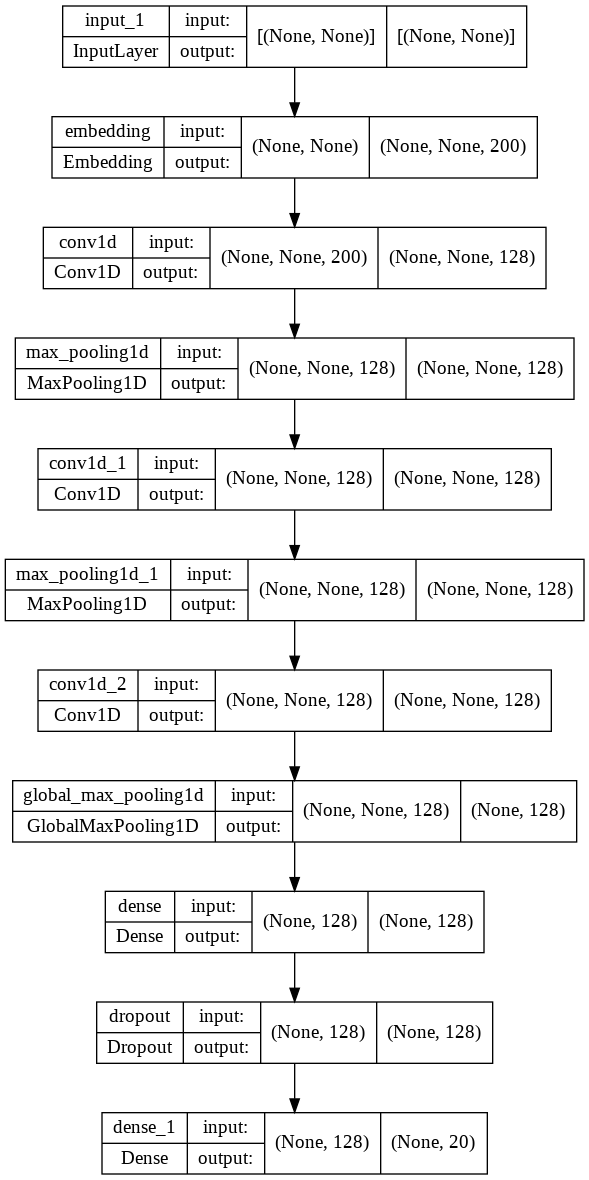

In [ ]:
keras.utils.plot_model(model1, "multi_input_and_output_model.png", show_shapes=True)

# **Training Model1**

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 10 epochs"
        patience=10,
        verbose=1,
    )
]

In [ ]:
epochs = 50
batch_size=64
model1.compile(
    loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
)
cp=ModelCheckpoint('model_1.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history1=model1.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val),batch_size=batch_size,callbacks=callbacks)

Epoch 1/50
142/142 [==============================] - 19s 12ms/step - loss: 2.7069 - acc: 0.1336 - val_loss: 2.0638 - val_acc: 0.2320
Epoch 2/50
142/142 [==============================] - 1s 8ms/step - loss: 1.7764 - acc: 0.3900 - val_loss: 1.2805 - val_acc: 0.5440
Epoch 3/50
142/142 [==============================] - 1s 8ms/step - loss: 1.2043 - acc: 0.5799 - val_loss: 1.0096 - val_acc: 0.6416
Epoch 4/50
142/142 [==============================] - 1s 8ms/step - loss: 0.8724 - acc: 0.6956 - val_loss: 1.1963 - val_acc: 0.6138
Epoch 5/50
142/142 [==============================] - 1s 8ms/step - loss: 0.6532 - acc: 0.7756 - val_loss: 0.8925 - val_acc: 0.7269
Epoch 6/50
142/142 [==============================] - 1s 8ms/step - loss: 0.5021 - acc: 0.8302 - val_loss: 0.7207 - val_acc: 0.7702
Epoch 7/50
142/142 [==============================] - 1s 8ms/step - loss: 0.3525 - acc: 0.8739 - val_loss: 0.8567 - val_acc: 0.7525
Epoch 8/50
142/142 [==============================] - 1s 8ms/step - loss: 

# **Plotting the Accuracy and validation Loss for model1**

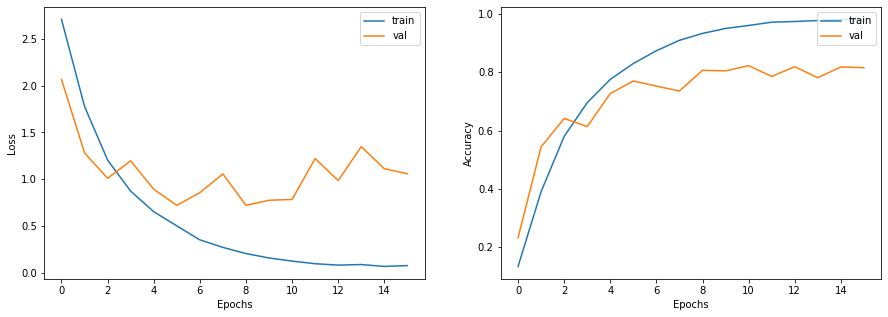

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history1.history["loss"])
ax1.plot(history1.history["val_loss"])
ax1.legend(["train", "val"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(history1.history["acc"])
ax2.plot(history1.history["val_acc"])
ax2.legend(["train", "val"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()

# **Testing Model1 with testing dataset**

In [ ]:
_, test_accuracy = model1.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 72.08%


# **Predicting using unknow raw text-Model1**

In [ ]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model1(x)
end_to_end_model = keras.Model(string_input, preds)

probabilities = end_to_end_model.predict([['Update and Re-fit a Model Call Description. update will update and (by default) re-fit a model']])

class_names[np.argmax(probabilities[0])]

'comp.os.ms-windows.misc'

## **1 dimensional CNN | Conv1D-without using Pre-trained Embedding**

Similar to the above model this one dimensional convolution without the pretrained embedding,we use tensorflow pure embedding.With similar features(activation,loss, optimazer etc). The testing accuracy 73.71% is highest, with 200 embedding dimension(D) and 30,000 vocabulary(Val) as again 100D and 20,000(Val). Slightly less that the above model.

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras import layers

# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(num_tokens, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a multiclass unit output layer, and squash it with a softmax:
predictions = layers.Dense(len(label_names), activation="softmax", name="predictions")(x)

model2 = tf.keras.Model(inputs, predictions)

# Compile the model with multiclass crossentropy loss and an rmsprop optimizer.
model2.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
print("Simple Neural Network")
model2.summary()

Simple Neural Network
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 200)         6000400   
                                                                 
 dropout_1 (Dropout)         (None, None, 200)         0         
                                                                 
 conv1d_3 (Conv1D)           (None, None, 128)         179328    
                                                                 
 conv1d_4 (Conv1D)           (None, None, 128)         114816    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                     

# **Graphical representation of Model2**


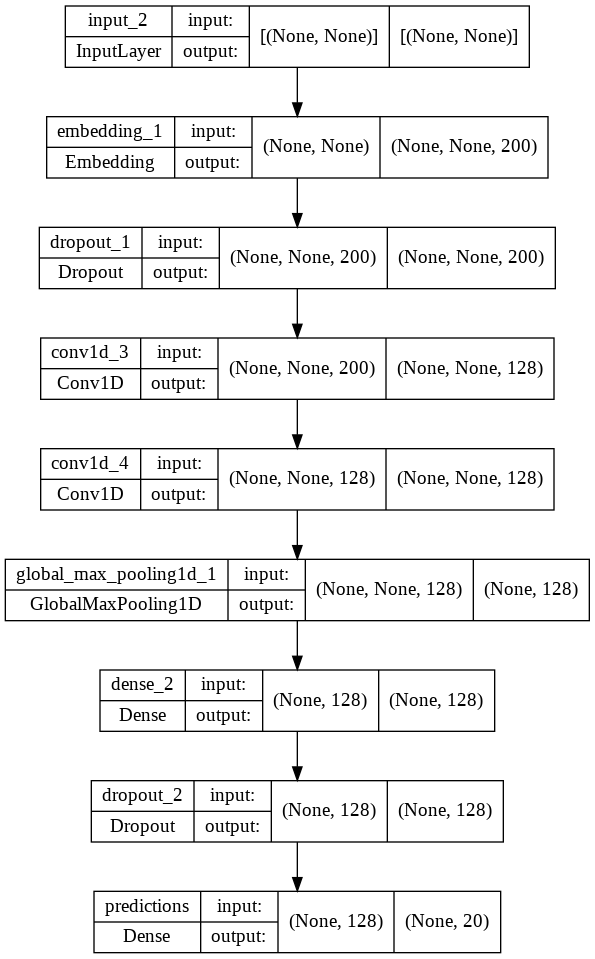

In [ ]:
keras.utils.plot_model(model2, "multi_input_and_output_model.png", show_shapes=True)

# **Training of Model2**

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=10,
        verbose=1,
    )
]

In [ ]:
epochs = 50
batch_size=64
# Fit the model using the train and test datasets.
cp=ModelCheckpoint('model_1.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history2=model2.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=epochs,batch_size=batch_size,callbacks=callbacks)

Epoch 1/50
142/142 [==============================] - 2s 11ms/step - loss: 2.9318 - accuracy: 0.0768 - val_loss: 2.6701 - val_accuracy: 0.1008
Epoch 2/50
142/142 [==============================] - 1s 9ms/step - loss: 2.5117 - accuracy: 0.1406 - val_loss: 2.2341 - val_accuracy: 0.2095
Epoch 3/50
142/142 [==============================] - 1s 9ms/step - loss: 2.1431 - accuracy: 0.2248 - val_loss: 1.9282 - val_accuracy: 0.3235
Epoch 4/50
142/142 [==============================] - 1s 10ms/step - loss: 1.7277 - accuracy: 0.3715 - val_loss: 1.4743 - val_accuracy: 0.4971
Epoch 5/50
142/142 [==============================] - 1s 9ms/step - loss: 1.2288 - accuracy: 0.5606 - val_loss: 1.0718 - val_accuracy: 0.6540
Epoch 6/50
142/142 [==============================] - 1s 9ms/step - loss: 0.7883 - accuracy: 0.7270 - val_loss: 0.8466 - val_accuracy: 0.7278
Epoch 7/50
142/142 [==============================] - 1s 9ms/step - loss: 0.5122 - accuracy: 0.8271 - val_loss: 0.7552 - val_accuracy: 0.7631
Epoc

# **Plotting Accuracy and validation loss of Model2**

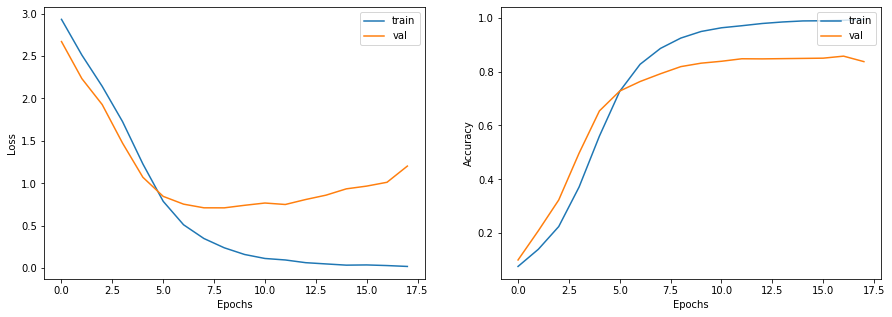

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history2.history["loss"])
ax1.plot(history2.history["val_loss"])
ax1.legend(["train", "val"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(history2.history["accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.legend(["train", "val"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()

# **Testing Model2 with Test dataset**

In [ ]:
_, test_accuracy = model2.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 73.46%


# **Predicting unknown text with Model2**

In [ ]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model2(x)
end_to_end_model = keras.Model(string_input, preds)

probabilities = end_to_end_model.predict(
    [['As a sanity check, if the embedding matrix has been generated properly. In the above, when I saw the first five entries of\nthe training set, the first entry was\n']]
)

class_names[np.argmax(probabilities[0])]
#df_train.texts[500]

'comp.windows.x'

# **RNN-Bidirectional LSTM Model 50 Unit**

Recurrent neural networks are a sort of neural network in which past time steps' outputs are used as inputs in the current time step.
Recurrent neural networks with Long Short-Term Memory (LSTM) are one of the most intriguing kinds of deep learning at the time.

Unlike other recurrent neural networks, the network’s internal gates allow the model to be trained successfully using backpropagation through time, and avoid the vanishing gradients problem.

They've been utilised to show world-class performance in areas as diverse as language translation, automatic picture captioning, and text production.

LSTMs vary from multilayer Perceptrons and convolutional neural networks in that they are especially developed to solve sequence prediction issues. Bidirectional LSTMs are a kind of LSTM that may be used to increase model performance in sequence classification issues.

Bidirectional Recurrent Neural Networks (RNNs) have a simple concept.
It entails replicating the network's initial recurrent layer so that there are two layers side by side, then feeding the input sequence as is to the first layer and a reversed duplicate of the input sequence to the second.
On the input sequence, bidirectional LSTMs train two LSTMs instead of one. The first is based on the original input sequence, while the second is based on a reversed replica of the original input sequence.

In this model the bidrectional LSTM improve performance, with similar hyperparameter like the first model. We use the pretrained embedding and loss='sparse_categorical_crossentropy',optimizer='adam',50 units of LSTM neutron and softmax activation. 

The test result is 78.4% with optimise epoch of less than 20, with batch size of 30. Most importantly the number of units[50,500]. This result is the best we could get with up to 300units, the result decline after 300units. This is a very good result and Bidirectional LSTM is know to improve performance.

In [ ]:
sequence_input = Input(shape=(200,), dtype='int64')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(units=300))(embedded_sequences)
preds = Dense(len(label_names), activation='softmax')(l_lstm)
model3 = Model(sequence_input, preds)
model3.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

print("Bidirectional LSTM")
model3.summary()

Bidirectional LSTM
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 200)]             0         
                                                                 
 embedding (Embedding)       multiple                  6000400   
                                                                 
 bidirectional_9 (Bidirectio  (None, 600)              1202400   
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 20)                12020     
                                                                 
Total params: 7,214,820
Trainable params: 1,214,420
Non-trainable params: 6,000,400
_________________________________________________________________


# **Graphical representation of model3**

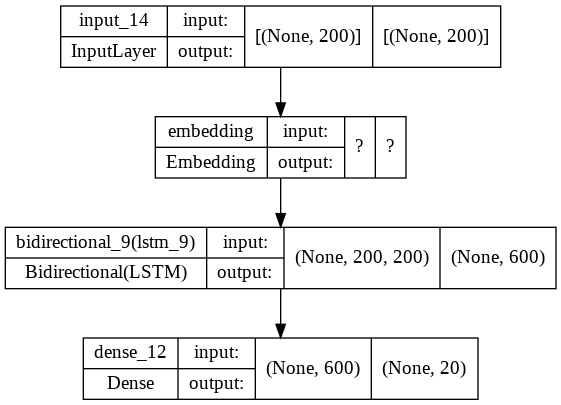

In [ ]:
keras.utils.plot_model(model3, "multi_input_and_output_model.png", show_shapes=True)

# **Training Model3**

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=10,
        verbose=1,
    )
]

In [ ]:
epochs=30
batch_size=20
cp=ModelCheckpoint('model_1.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history3=model3.fit(x_train, y_train, validation_data=(x_val,y_val),epochs=epochs, batch_size=batch_size,callbacks=(callbacks,cp))

Epoch 1/30
453/453 [==============================] - ETA: 0s - loss: 1.8469 - acc: 0.4023
Epoch 1: val_acc improved from -inf to 0.57844, saving model to model_1.hdf5
453/453 [==============================] - 23s 44ms/step - loss: 1.8469 - acc: 0.4023 - val_loss: 1.2148 - val_acc: 0.5784
Epoch 2/30
452/453 [============================>.] - ETA: 0s - loss: 0.8964 - acc: 0.7041
Epoch 2: val_acc improved from 0.57844 to 0.73045, saving model to model_1.hdf5
453/453 [==============================] - 19s 42ms/step - loss: 0.8960 - acc: 0.7042 - val_loss: 0.8400 - val_acc: 0.7304
Epoch 3/30
453/453 [==============================] - ETA: 0s - loss: 0.5639 - acc: 0.8199
Epoch 3: val_acc improved from 0.73045 to 0.79761, saving model to model_1.hdf5
453/453 [==============================] - 19s 41ms/step - loss: 0.5639 - acc: 0.8199 - val_loss: 0.6320 - val_acc: 0.7976
Epoch 4/30
451/453 [============================>.] - ETA: 0s - loss: 0.3775 - acc: 0.8786
Epoch 4: val_acc improved from

## **Plotting accuracy and loss of Model3**

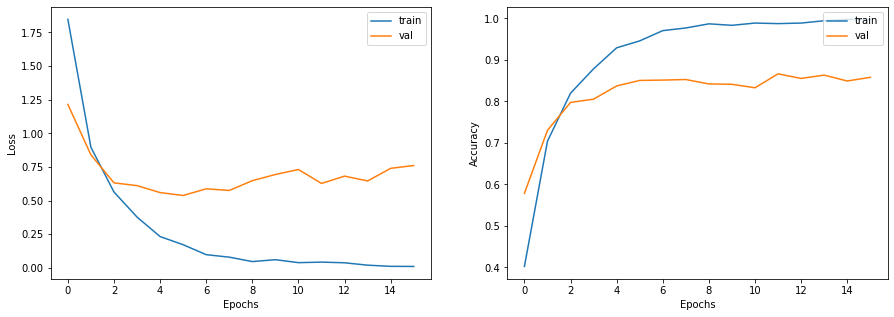

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history3.history["loss"])
ax1.plot(history3.history["val_loss"])
ax1.legend(["train", "val"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(history3.history["acc"])
ax2.plot(history3.history["val_acc"])
ax2.legend(["train", "val"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()

# **Testing Model3 on Testing data**

In [ ]:
_, test_accuracy = model3.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 78.47%


In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
def create_model():
  sequence_input = Input(shape=(200,), dtype='int64')
  embedded_sequences = embedding_layer(sequence_input)
  l_lstm = Bidirectional(LSTM(units=300))(embedded_sequences)
  preds = Dense(len(label_names), activation='softmax')(l_lstm)
  model3 = Model(sequence_input, preds)
  model3.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
  return model3

# **Predicting with Model3**

In [ ]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model3(x)
end_to_end_model = keras.Model(string_input, preds)

probabilities = end_to_end_model.predict(
    [['Jon playes cricket His favourite player is MS DhoniSometimes he loves to play football']]
)

class_names[np.argmax(probabilities[0])]

'rec.sport.baseball'

# **1 dimensional CNN MODEL- Developed as a function**

In [ ]:
def ConvNet1(embeddings, num_tokens, embedding_dim, label_code):
    
    embedding_layer = Embedding(
        num_tokens,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,)
    
    sequence_input = Input(shape=(None,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
    x = layers.MaxPooling1D(5)(x)
    x = layers.Conv1D(128, 5, activation="relu")(x)
    x = layers.MaxPooling1D(5)(x)
    x = layers.Conv1D(128, 5, activation="relu")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    preds = Dense(len(label_names), activation='softmax')(x)
    model = keras.Model(sequence_input, preds)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer="adam",
                  metrics=['acc'])
    model.summary()
    return model

In [ ]:
model4 = ConvNet1(embedding_matrix, num_tokens,embedding_dim,label_code)

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 200)         6000400   
                                                                 
 conv1d_5 (Conv1D)           (None, None, 128)         128128    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, None, 128)        0         
 1D)                                                      

# **Graph of Model4**

In [ ]:
keras.utils.plot_model(model4, "multi_input_and_output_model.png", show_shapes=True)

# **Training of Model4**

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=10,
        verbose=1,
    )
]

In [ ]:
epochs=50
batch_size=64
cp=ModelCheckpoint('model_1.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

In [ ]:
model4 = ConvNet1(embedding_matrix, num_tokens, embedding_dim,label_code)
history4 = model4.fit(x_train, y_train, epochs=epochs, shuffle=True,validation_data=(x_val,y_val), batch_size=batch_size,callbacks=(callbacks,cp))

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 200)         6000400   
                                                                 
 conv1d_8 (Conv1D)           (None, None, 128)         128128    
                                                                 
 max_pooling1d_4 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, None, 128)        0         
 1D)                                                      

## **Plotting accuracy and loss of Model4**

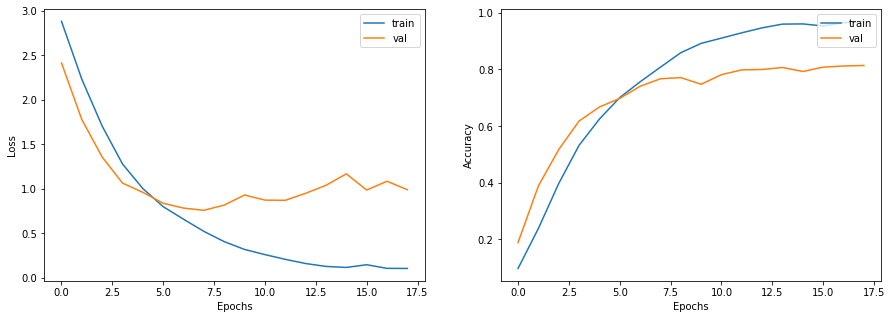

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history4.history["loss"])
ax1.plot(history4.history["val_loss"])
ax1.legend(["train", "val"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(history4.history["acc"])
ax2.plot(history4.history["val_acc"])
ax2.legend(["train", "val"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()

## **Testing Model4**

In [ ]:
_, test_accuracy = model4.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 72.34%


# **Predicting with Model4**

In [ ]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model4(x)
end_to_end_model = keras.Model(string_input, preds)

probabilities = end_to_end_model.predict(
    [["Jon playes cricket His favourite player is MS Dhoni Sometimes he loves to play football"]]
)

class_names[np.argmax(probabilities[0])]

'rec.sport.baseball'